In [1]:
import os
import cv2
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

# ---- Config ----
VIDEO_PATH = "vid1.mov"
FRAME_SAVE_PATH = "frames/"
FRAME_INTERVAL = 60  # every N frames
MODEL_NAME = "openai/clip-vit-base-patch32"

# ---- Create frame directory -----------
# ---- Load CLIP model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# ---- Step 1: Extract Frames ----
def extract_frames(video_path, interval, output_dir):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(frame_rgb)
            image_path = os.path.join(output_dir, f"frame_{saved_count:04d}.png")
            image_pil.save(image_path)
            saved_count += 1

        frame_count += 1
    cap.release()

# ---- Step 2: Get CLIP Embeddings ----
def get_clip_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze().cpu().numpy()

# ---- Run Pipeline ----
print("Extracting frames...")
extract_frames(VIDEO_PATH, FRAME_INTERVAL, FRAME_SAVE_PATH)

print("Computing embeddings...")
embeddings = []
image_files = sorted([f for f in os.listdir(FRAME_SAVE_PATH) if f.endswith(".png")])

for filename in image_files:
    path = os.path.join(FRAME_SAVE_PATH, filename)
    emb = get_clip_embedding(path)
    embeddings.append((filename, emb))

print(f"Computed embeddings for {len(embeddings)} frames")

# # Optional: Save embeddings to file
# np.save("clip_embeddings.npy", embeddings)
# print("Saved embeddings to clip_embeddings.npy")


d:\Projekty\Python\GeoGuesser\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Projekty\Python\GeoGuesser\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\koriu\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activa

Extracting frames...
Computing embeddings...
Computed embeddings for 9 frames


In [ ]:
import os
import cv2
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import faiss

# ---- Config ----
VIDEO_PATH = "sample_outdoor_video.mp4"
FRAME_SAVE_PATH = "frames/"
REFERENCE_DATA_PATH = "reference_images/"
EMBEDDING_SAVE_PATH = "clip_embeddings.npy"
INDEX_SAVE_PATH = "faiss_index.bin"
FRAME_INTERVAL = 60  # every N frames
MODEL_NAME = "openai/clip-vit-base-patch32"

# ---- Create directories ----
os.makedirs(FRAME_SAVE_PATH, exist_ok=True)
os.makedirs(REFERENCE_DATA_PATH, exist_ok=True)

# ---- Load CLIP model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# ---- Step 1: Extract Frames ----
def extract_frames(video_path, interval, output_dir):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(frame_rgb)
            image_path = os.path.join(output_dir, f"frame_{saved_count:04d}.png")
            image_pil.save(image_path)
            saved_count += 1

        frame_count += 1
    cap.release()

# ---- Step 2: Get CLIP Embeddings ----
def get_clip_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze().cpu().numpy()


# ---- Step 3: Build FAISS Index from Reference Images ----
def build_faiss_index(reference_dir):
    reference_embeddings = []
    filenames = []
    for file in sorted(os.listdir(reference_dir)):
        if file.endswith(".png") or file.endswith(".jpg"):
            filepath = os.path.join(reference_dir, file)
            emb = get_clip_embedding(filepath)
            reference_embeddings.append(emb)
            filenames.append(file)

    reference_embeddings = np.vstack(reference_embeddings).astype("float32")
    index = faiss.IndexFlatL2(reference_embeddings.shape[1])
    index.add(reference_embeddings)
    faiss.write_index(index, INDEX_SAVE_PATH)
    np.save("reference_filenames.npy", filenames)
    print("FAISS index built and saved.")
    return index, filenames

# ---- Step 4: Query Index with Video Frame Embeddings ----
def query_index(index, query_embeddings, filenames, k=3):
    results = []
    for frame_name, emb in query_embeddings:
        emb = emb.astype("float32").reshape(1, -1)
        D, I = index.search(emb, k)
        matched = [(filenames[i], float(D[0][j])) for j, i in enumerate(I[0])]
        results.append((frame_name, matched))
    return results

# ---- Run Pipeline ----
print("Extracting frames...")
extract_frames(VIDEO_PATH, FRAME_INTERVAL, FRAME_SAVE_PATH)

print("Computing embeddings for video frames...")
embeddings = []
image_files = sorted([f for f in os.listdir(FRAME_SAVE_PATH) if f.endswith(".png")])


for filename in image_files:
    path = os.path.join(FRAME_SAVE_PATH, filename)
    emb = get_clip_embedding(path)
    embeddings.append(emb)

final_embeddings_np = np.stack(embeddings)

np.save(EMBEDDING_SAVE_PATH, final_embeddings_np)
print(f"Saved embeddings to {EMBEDDING_SAVE_PATH}")

print("Building FAISS index from reference images...")
index, ref_filenames = build_faiss_index(REFERENCE_DATA_PATH)

print("Querying index with video frame embeddings...")
results = query_index(index, final_embeddings_np, ref_filenames)

for frame, matches in results:
    print(f"\nFrame: {frame}")
    for fname, dist in matches:
        print(f"  Match: {fname} | Distance: {dist:.2f}")


Extracting frames...
Computing embeddings for video frames...
Saved embeddings to clip_embeddings.npy
Building FAISS index from reference images...


ValueError: need at least one array to concatenate

In [2]:
import os
import cv2
import json
import numpy as np

from modules.driving_side import analyze_driving_side

# Config
VIDEO_PATH = "vid1.mov"
FRAME_SAVE_PATH = "frames/"
FRAME_INTERVAL = 30

# Prepare frame directory
os.makedirs(FRAME_SAVE_PATH, exist_ok=True)

# Step 1: Extract Frames

def extract_frames(video_path, interval, output_dir):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            path = os.path.join(output_dir, f"frame_{saved_count:04d}.png")
            cv2.imwrite(path, frame)
            saved_count += 1

        frame_count += 1
    cap.release()

print("Extracting frames...")
extract_frames(VIDEO_PATH, FRAME_INTERVAL, FRAME_SAVE_PATH)

Extracting frames...


## OCR

In [12]:
%load_ext autoreload
%autoreload 2 
from modules.language_ocr import detect_languages

FRAME_SAVE_PATH = "frames/"
# Step 2: Run All Modules
print("Running language OCR module...")
language_results = detect_languages(FRAME_SAVE_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running language OCR module...
EasyOCR reader with GPU.

Processing file: frames/frame_0000.png
  No text detected in frame_0000.png by any reader.

Processing file: frames/frame_0001.png
  No text detected in frame_0001.png by any reader.

Processing file: frames/frame_0002.png
  No text detected in frame_0002.png by any reader.

Processing file: frames/frame_0003.png
  No text detected in frame_0003.png by any reader.

Processing file: frames/frame_0004.png
  No text detected in frame_0004.png by any reader.

Processing file: frames/frame_0005.png
  No text detected in frame_0005.png by any reader.

Processing file: frames/frame_0006.png
  No text detected in frame_0006.png by any reader.

Processing file: frames/frame_0007.png
  No text detected in frame_0007.png by any reader.

Processing file: frames/frame_0008.png
  No text detected in frame_0008.png by any reader.

Processing file: frames/fra

## Strona jazdy

In [8]:
print("Running driving side analysis module...")
driving_result = analyze_driving_side("mirrored_video.mp4")
print(driving_result)

Running driving side analysis module...
left


## Podsumowanie

In [13]:
# Step 3: Inference Logic
results = {
    "language": language_results,
    "driving_side": driving_result,
    "notes": []
}

if "Traditional Chinese" in language_results:
    results["notes"].append("Detected Traditional Chinese → Possibly Hong Kong or Taiwan")

if driving_result == "right":
    results["notes"].append("Right side driving → Eliminate UK, India, Japan")

# Print Results
print(json.dumps(results, indent=2))

{
  "language": [],
  "driving_side": "left",
  "notes": []
}


In [ ]:
import cv2

# Open the video file
video = cv2.VideoCapture("vid1.mov")

# Get video properties
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
output = cv2.VideoWriter("mirrored_video.mp4", fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = video.read()
    if not ret:
        break  # Exit when video ends
    
    # Flip each frame horizontally (mirror effect)
    mirrored_frame = cv2.flip(frame, 1)

    # Write the flipped frame to the output video
    output.write(mirrored_frame)

# Release resources
video.release()
output.release()

## YOLO

YOLO\Datasets\FullIJCNN2013\00003.ppm


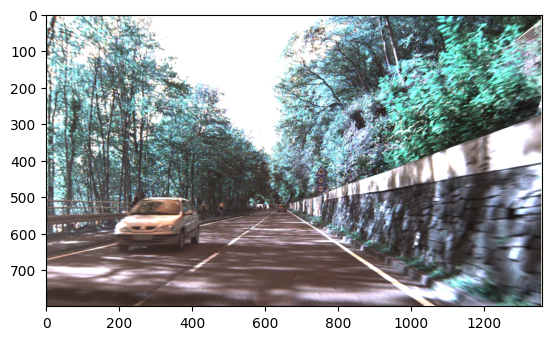

In [9]:
import cv2 as cv
import os
from matplotlib import pyplot as plt
path =os.path.join('YOLO','Datasets','FullIJCNN2013','00003.ppm')
img = cv.imread(path)
print(path)
plt.imshow(img)

In [ ]:
# Pseudo-code compatible version of using CRAFT for text detection
# Assumes you have CRAFT model weights and craft_pytorch implementation
# Actual inference part will be a stub here due to no GPU or model in this environment

import os
import glob
from PIL import Image
import numpy as np
from craft import CRAFT
from craft_utils import getDetBoxes
from imgproc import loadImage
import torch

# Placeholder for actual CRAFT inference
def dummy_craft_inference(image_path):
    # Simulated result: list of bounding boxes as 4 points each
    # Format: [ [ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ], ... ]
    return [
        [[100, 50], [140, 50], [140, 80], [100, 80]],
        [[200, 100], [250, 100], [250, 130], [200, 130]]
    ]


def convert_bbox_to_yolo(bbox, img_width, img_height):
    x_coords = [point[0] for point in bbox]
    y_coords = [point[1] for point in bbox]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2.0 / img_width
    y_center = (y_min + y_max) / 2.0 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return x_center, y_center, width, height

def process_dataset_with_craft(directory):
    image_files = glob.glob(os.path.join(directory, "*.jpg"))
    craft_net = CRAFT()
    craft_net.load_state_dict(torch.load('craft_mlt_25k.pth', map_location='gpu'))
    craft_net.eval()

    for image_path in image_files:
        txt_path = image_path.replace(".jpg", ".txt")
        if not os.path.exists(txt_path):
            continue

        # Read original annotations
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Change all class IDs to 1
        updated_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                parts[0] = '1'
                updated_lines.append(" ".join(parts))

        # Read image
        img = Image.open(image_path)
        img_width, img_height = img.size

        # CRAFT text detection
        text_boxes =  test_net(craft_net, img, 0.7, 0.4, 0.4, False)

        for bbox in text_boxes:
            x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
            updated_lines.append(f"0 {x_center} {y_center} {width} {height}")

        # Save back to file
        with open(txt_path, "w") as f:
            f.write("\n".join(updated_lines))

    print("Processed with CRAFT (dummy inference used here).")

# Replace with the real CRAFT model inference for deployment.
# process_dataset_with_craft("/path/to/your/dataset")



In [ ]:
process_dataset("/path/to/your/dataset")

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")


# Perform object detection on an image




image 1/1 d:\Projekty\Python\GeoGuesser\frames\frame_229.jpg: 384x640 1 person, 2 cars, 1 truck, 397.6ms
Speed: 145.7ms preprocess, 397.6ms inference, 920.9ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
results = model("frames/frame_229.jpg")
results[0].show()

In [9]:
results[10].show()

NameError: name 'results' is not defined

In [ ]:
import ipywidgets as widgets


IntSlider(value=7, continuous_update=False, description='Test:', max=10)

In [8]:
import cv2 as cv
from matplotlib import pyplot as plt
for f in results:
    plt.imshow(f.plot())


MemoryError: Unable to allocate 2.64 MiB for an array with shape (720, 1280, 3) and data type bool

Error in callback <function _draw_all_if_interactive at 0x000002071E020A40> (for post_execute), with arguments args (),kwargs {}:


MemoryError: bad allocation

MemoryError: Unable to allocate 3.52 MiB for an array with shape (720, 1280, 4) and data type uint8

<Figure size 640x480 with 1 Axes>

# SIGN

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/cardetection")

print("Path to dataset files:", path)

100%|██████████| 99.8M/99.8M [00:25<00:00, 4.17MB/s]

Extracting files...


Path to dataset files: C:\Users\koriu\.cache\kagglehub\datasets\pkdarabi\cardetection\versions\5


In [14]:
# Import Essential Libraries
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

In [18]:
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

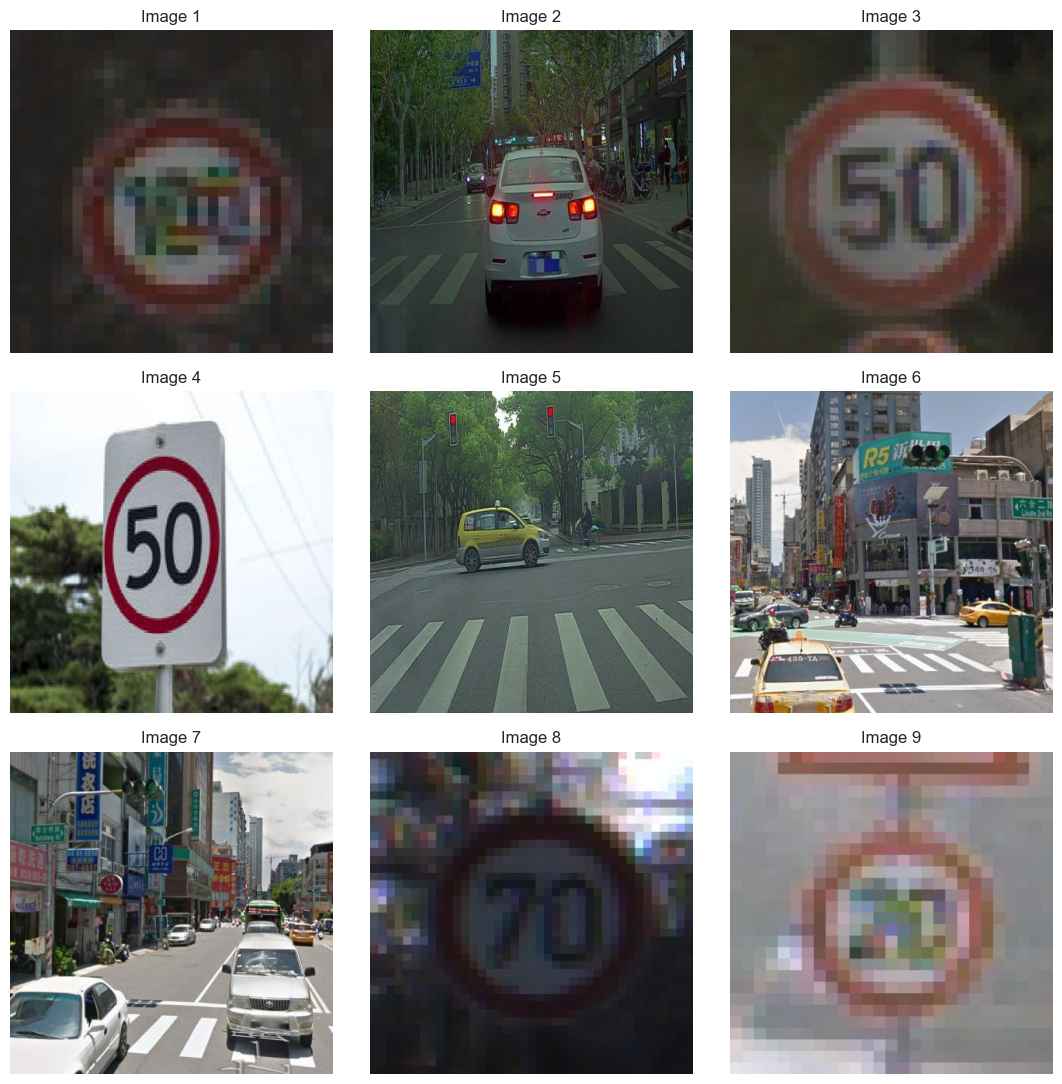

In [20]:
Image_dir = 'car/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Get the size of the image
image = cv2.imread("car/train/images/00000_00000_00012_png.rf.23f94508dba03ef2f8bd187da2ec9c26.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.



image 1/1 d:\Projekty\Python\GeoGuesser\car\train\images\FisheyeCamera_1_00228_png.rf.e7c43ee9b922f7b2327b8a00ccf46a4c.jpg: 640x640 1 truck, 1 stop sign, 72.0ms
Speed: 25.1ms preprocess, 72.0ms inference, 25.7ms postprocess per image at shape (1, 3, 640, 640)


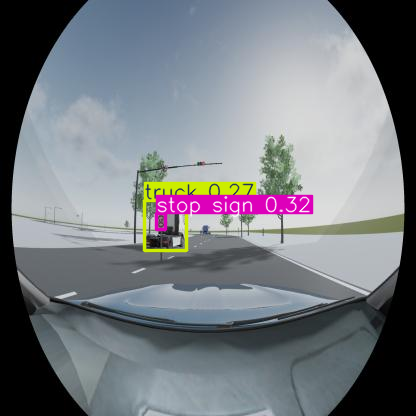

In [24]:
# Use a pretrained YOLOv8n model
model = YOLO("yolo11n.pt") 

# Use the model to detect object
image = "car/train/images/FisheyeCamera_1_00228_png.rf.e7c43ee9b922f7b2327b8a00ccf46a4c.jpg"
result_predict = model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [25]:
!pip install --upgrade ultralytics ray

ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.32 Requires-Python >=3.7,<=3.11; 8.0.33 Requires-Python >=3.7,<=3.11; 8.0.34 Requires-Python >=3.7,<=3.

In [27]:
Final_model = YOLO('yolo11n.pt')  

# Training The Final Model
Result_Final_model = Final_model.train(data="car/data.yaml",epochs = 30, batch = -1, optimizer = 'auto')

New https://pypi.org/project/ultralytics/8.3.154 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, o

train: Scanning D:\Projekty\Python\GeoGuesser\car\train\labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:22<00:00, 156.43it/s]


train: New cache created: D:\Projekty\Python\GeoGuesser\car\train\labels.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 970) 4.00G total, 0.28G reserved, 0.07G allocated, 3.65G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2592765       6.456         0.566         228.2          1140        (1, 3, 640, 640)                    list
     2592765       12.91         0.749         38.34         172.9        (2, 3, 640, 640)                    list
     2592765       25.82         1.160          46.7         302.8        (4, 3, 640, 640)                    list
     2592765       51.65         1.764         65.87         169.2        (8, 3, 640, 640)                    list
     2592765       103.3         3.022         119.7         270.9       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 9 for CUDA:0 2.

train: Scanning D:\Projekty\Python\GeoGuesser\car\train\labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 2.21.4 MB/s, size: 19.9 KB)


val: Scanning D:\Projekty\Python\GeoGuesser\car\valid\labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:05<00:00, 155.24it/s]


val: New cache created: D:\Projekty\Python\GeoGuesser\car\valid\labels.cache
Plotting labels to d:\Projekty\Python\GeoGuesser\runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0004921875), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to d:\Projekty\Python\GeoGuesser\runs\detect\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.47G     0.8647      3.556      1.197          7        640: 100%|██████████| 393/393 [01:56<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]

                   all        801        944      0.231      0.435       0.26      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.74G     0.7903      2.611      1.114          4        640: 100%|██████████| 393/393 [01:49<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.37it/s]


                   all        801        944      0.332      0.486      0.384       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.75G     0.7837      2.212      1.103          3        640: 100%|██████████| 393/393 [01:46<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.28it/s]

                   all        801        944      0.448      0.557      0.544      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.76G     0.7498      1.907       1.09          4        640: 100%|██████████| 393/393 [01:46<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.26it/s]


                   all        801        944      0.616       0.59      0.615      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.78G     0.7354      1.658      1.072          6        640: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.44it/s]

                   all        801        944      0.737      0.613      0.682      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.79G     0.6981      1.466      1.061          2        640: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]

                   all        801        944      0.772      0.714      0.793      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.81G     0.6894       1.33      1.046          4        640: 100%|██████████| 393/393 [01:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:09<00:00,  4.52it/s]

                   all        801        944      0.879      0.731      0.823      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.82G     0.6651      1.216      1.039          4        640: 100%|██████████| 393/393 [01:48<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:12<00:00,  3.70it/s]

                   all        801        944      0.841      0.759      0.841      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.84G      0.659      1.148      1.032          4        640: 100%|██████████| 393/393 [01:48<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.36it/s]

                   all        801        944      0.887      0.754      0.854      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.85G     0.6467      1.086      1.027          3        640: 100%|██████████| 393/393 [01:49<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.27it/s]

                   all        801        944      0.888      0.774      0.869      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.86G     0.6481      1.003      1.025          2        640: 100%|██████████| 393/393 [01:49<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  3.99it/s]

                   all        801        944      0.917      0.808      0.895      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.88G     0.6254     0.9805      1.013          5        640: 100%|██████████| 393/393 [01:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  3.98it/s]

                   all        801        944      0.931      0.793      0.892      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       1.9G     0.6266     0.9343      1.015          3        640: 100%|██████████| 393/393 [01:48<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.49it/s]

                   all        801        944      0.864      0.826      0.893      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.91G     0.6131     0.9292      1.009          3        640: 100%|██████████| 393/393 [01:48<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.40it/s]

                   all        801        944      0.931       0.82      0.906       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.93G     0.6003     0.8538     0.9959          3        640: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]


                   all        801        944      0.914      0.836      0.905      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.94G     0.5969     0.8459     0.9958          2        640: 100%|██████████| 393/393 [02:03<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]

                   all        801        944       0.95      0.815      0.908      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.96G     0.5945     0.8185     0.9933          2        640: 100%|██████████| 393/393 [02:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

                   all        801        944      0.933       0.84      0.911      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.96G     0.5927     0.8021     0.9934          6        640: 100%|██████████| 393/393 [02:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13<00:00,  3.42it/s]


                   all        801        944      0.939      0.838      0.915      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.99G     0.5833     0.7704     0.9866          5        640: 100%|██████████| 393/393 [02:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.32it/s]

                   all        801        944      0.949      0.837      0.916      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         2G     0.5727     0.7447     0.9865          8        640: 100%|██████████| 393/393 [01:55<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:09<00:00,  4.51it/s]

                   all        801        944      0.934      0.857      0.927      0.792


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.52G     0.5697      0.549     0.9589          2        640: 100%|██████████| 393/393 [01:47<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]

                   all        801        944      0.953      0.852      0.933        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.52G     0.5564     0.5121     0.9483          3        640: 100%|██████████| 393/393 [01:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.25it/s]

                   all        801        944      0.957      0.852      0.932      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.52G     0.5511     0.4922     0.9455          2        640: 100%|██████████| 393/393 [01:51<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:12<00:00,  3.67it/s]

                   all        801        944      0.946      0.857      0.934      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.52G     0.5407      0.474     0.9396          2        640: 100%|██████████| 393/393 [01:46<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:09<00:00,  4.61it/s]

                   all        801        944       0.96      0.851      0.937      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.52G     0.5397     0.4665     0.9401          3        640: 100%|██████████| 393/393 [01:43<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.49it/s]

                   all        801        944      0.951      0.854      0.937      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.52G     0.5277     0.4459     0.9364          2        640: 100%|██████████| 393/393 [01:43<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.24it/s]

                   all        801        944      0.959      0.864      0.945       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.52G      0.522     0.4335     0.9316          5        640: 100%|██████████| 393/393 [01:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:09<00:00,  4.59it/s]

                   all        801        944       0.94      0.862      0.939      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.52G     0.5147     0.4215     0.9233          2        640: 100%|██████████| 393/393 [01:44<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.21it/s]

                   all        801        944      0.953      0.868      0.946       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.52G     0.5043     0.4101      0.917          3        640: 100%|██████████| 393/393 [01:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.30it/s]

                   all        801        944      0.961      0.863      0.945      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.52G     0.5032     0.4029      0.919          2        640: 100%|██████████| 393/393 [01:50<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.13it/s]

                   all        801        944      0.934      0.887      0.948      0.822



30 epochs completed in 1.019 hours.
Optimizer stripped from d:\Projekty\Python\GeoGuesser\runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from d:\Projekty\Python\GeoGuesser\runs\detect\train2\weights\best.pt, 5.5MB

Validating d:\Projekty\Python\GeoGuesser\runs\detect\train2\weights\best.pt...
Ultralytics 8.3.152  Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.16it/s]


                   all        801        944      0.934      0.887      0.948      0.822
           Green Light         87        122      0.834      0.779      0.841      0.491
             Red Light         74        108      0.875      0.777      0.832      0.521
       Speed Limit 100         52         52      0.928      0.942      0.979      0.882
       Speed Limit 110         17         17      0.883      0.892      0.945      0.871
       Speed Limit 120         60         60          1      0.899       0.99       0.91
        Speed Limit 20         56         56      0.981      0.904      0.978      0.858
        Speed Limit 30         71         74      0.944      0.959       0.98      0.924
        Speed Limit 40         53         55      0.897      0.945      0.983      0.871
        Speed Limit 50         68         71      0.887      0.873      0.968      0.868
        Speed Limit 60         76         76      0.946      0.921      0.962      0.873
        Speed Limit 7

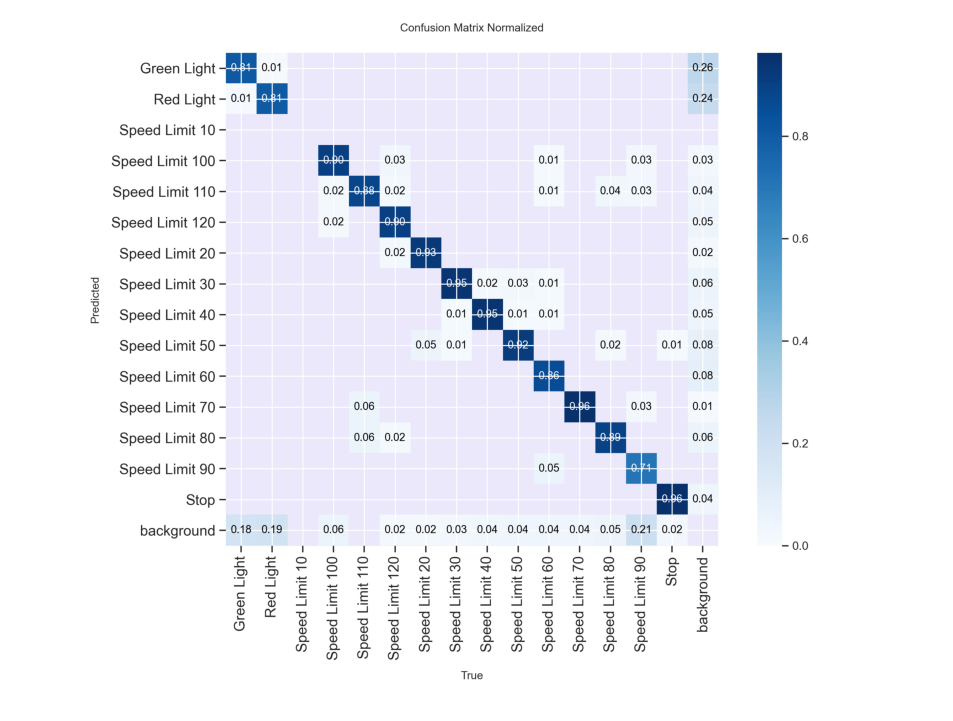

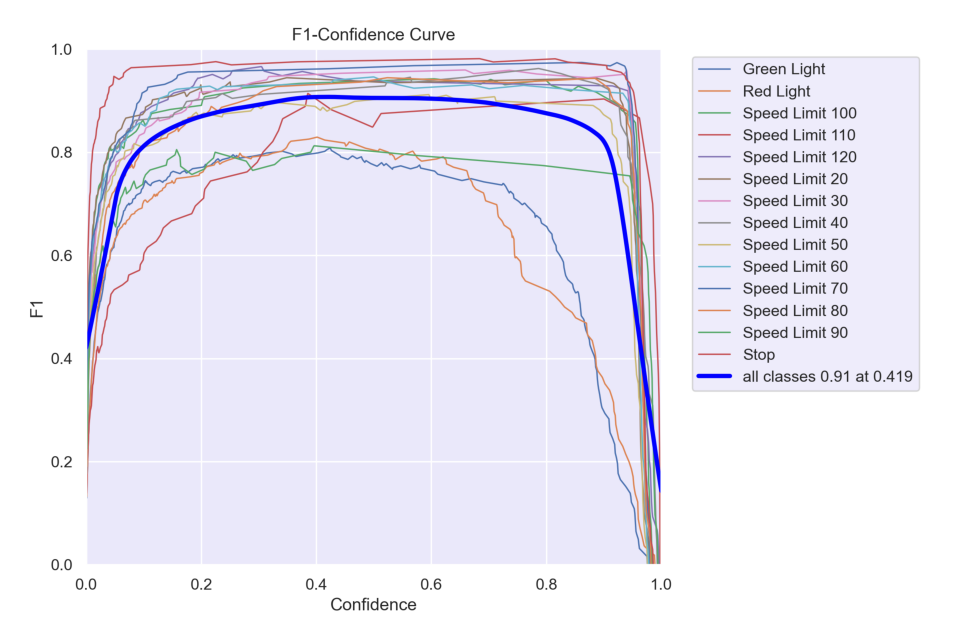

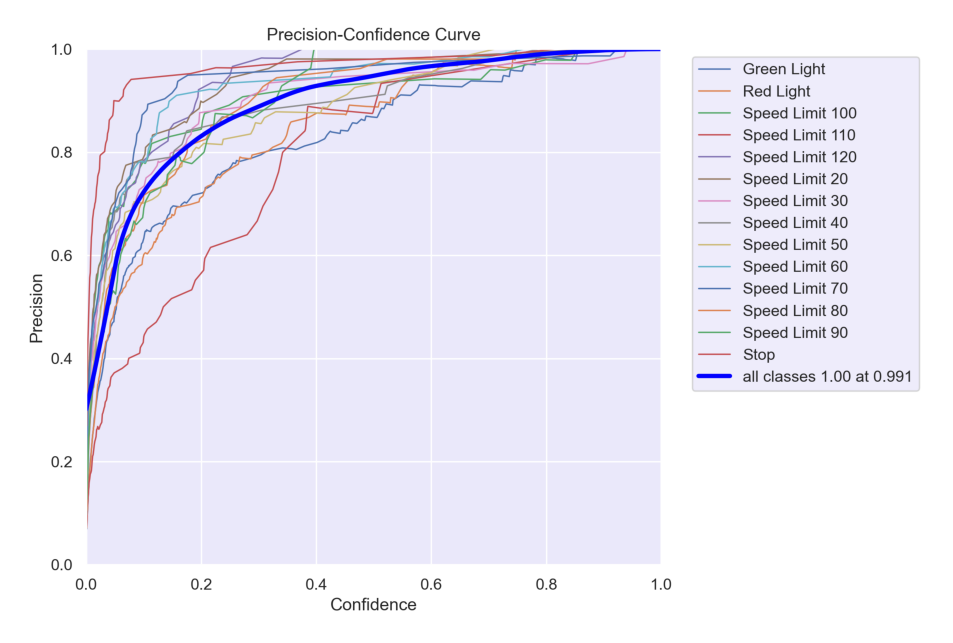

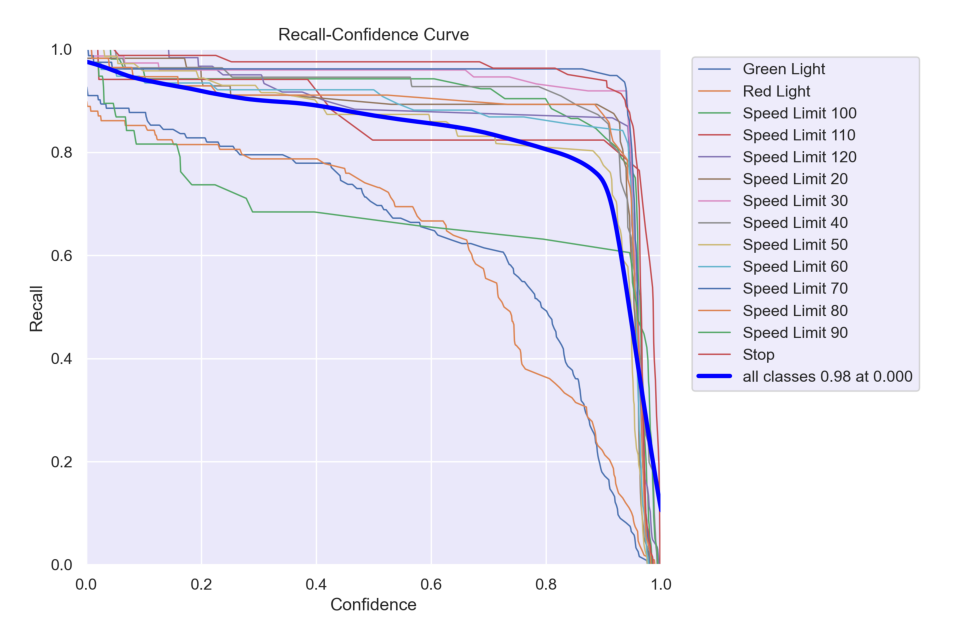

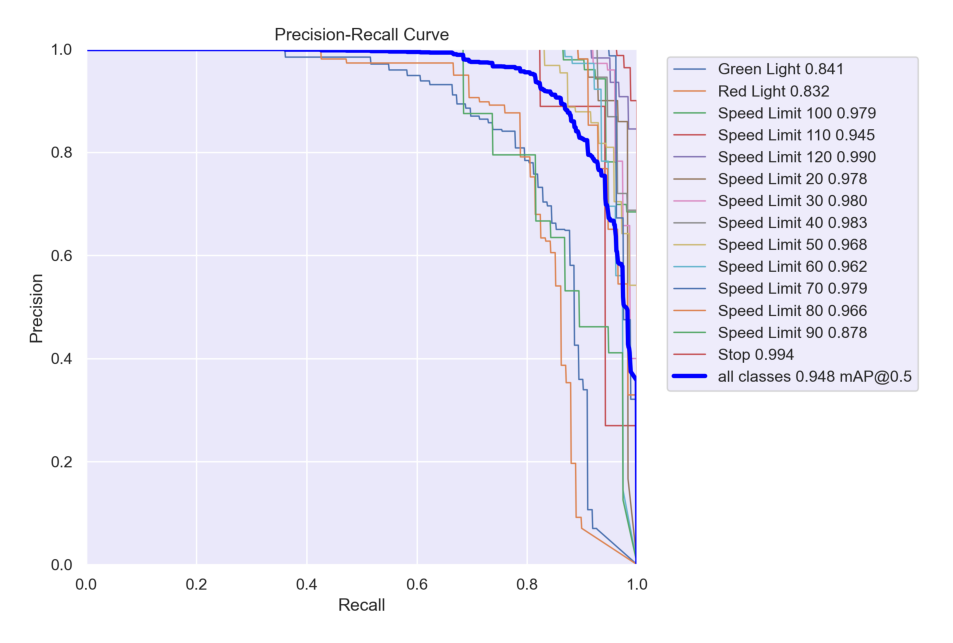

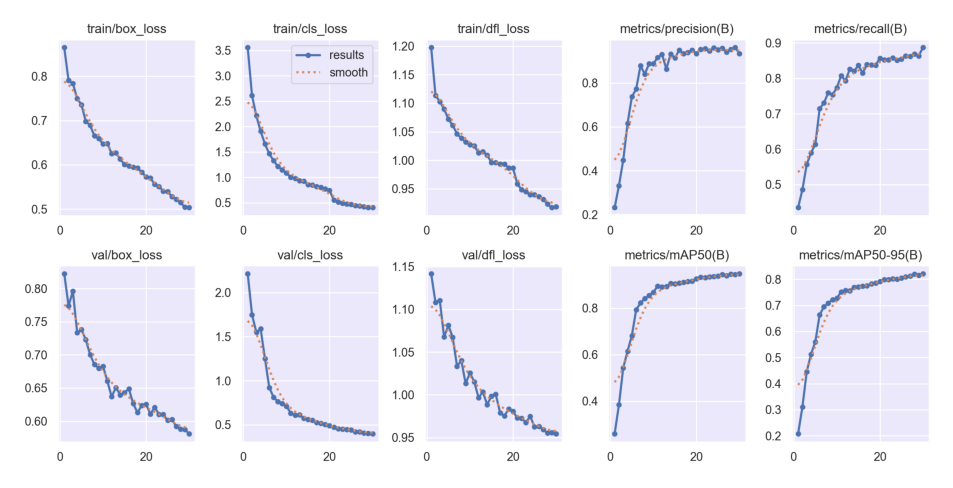

In [33]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = 'runs\\detect\\train2'

# Display the images
display_images(post_training_files_path, image_files)

In [35]:
import cv2 as cv
cap = cv.VideoCapture("mirrored_video.mp4")

width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS)
fourcc = cv.VideoWriter_fourcc(*"mp4v")  # lub 'XVID' dla AVI
out = cv.VideoWriter("output_detected.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 5. Detekcja
    results = Final_model(frame)[0]  # YOLOv8 returns list; take the first

    # 6. Rysowanie wykryć
    annotated_frame = results.plot()  # rysuje boxy, etykiety itd.

    # 7. Zapis klatki
    out.write(annotated_frame)

# 8. Zwolnienie zasobów
cap.release()
out.release()


0: 384x640 (no detections), 109.3ms
Speed: 3.8ms preprocess, 109.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 17.9ms
Speed: 2.7ms preprocess, 17.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 18.2ms
Speed: 5.0ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 17.8ms
Speed: 3.7ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 16.8ms
Speed: 2.9ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 89.8ms
Speed: 4.5ms preprocess, 89.8ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 18.4ms
Speed: 3.1ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 25.4ms
Speed: 3.0ms preprocess, 25.4ms